In [ ]:
%load_ext autoreload
%autoreload 2

# import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
# os.environ['PYTHONPATH'] = ':'.join(sys.path)

In [ ]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import uproot
from scipy.stats import iqr

from hepattn.experiments.clic.performance.performance import Performance
from hepattn.experiments.clic.performance.plot_helper_event import *
from hepattn.experiments.clic.performance.plot_helper_particle import *

In [ ]:
save_dir = "/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/maskformer_infer_best"
SAVE_FIG = True

In [ ]:
os.makedirs(save_dir, exist_ok=True)

In [ ]:
net_dict = {
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFix_20250611-T181526/ckpts/epoch=172-val_loss=3.29018__test.root",
    # "mpflow": "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test.root",
    # "mpflow":   "/storage/agrp/dmitrykl/hgpf/hepattn/src/hepattn/experiments/clic/logs/CLIC_Pflow_FullDiceFoc_20250612-T131052/ckpts/epoch=195-val_loss=3.42870__test__common.root",
    # "mpflow": "/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_Oldversion_20250706-T010552/ckpts/epoch=056-val_loss=4.08113__test.root",
    "mpflow": "/share/gpu1/syw24/hepattn/logs/CLIC_Pflow_FullDiceFocFix_bf16_mixed_1gpu_oldloss_modified_20250708-T054437/ckpts/epoch=012-val_loss=4.04678__test.root",
    # "hgpflow": "/storage/agrp/nilotpal/HGPFlow_v2/experiments/hgpflow_v2/clicxminixbig1x2xs2xxxds7kirm1yo/inference/ee_qq_new/pred_test_p8_ee_qq_ecm380_20k_seg_bw0.3_nocut_merged.root",
    # 'hgpflow'
}

In [ ]:
perf_obj = Performance(
    # truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_common_raw.root",
    truth_path="/share/gpu1/syw24/dmitrii_clic/test_clic_raw.root",
    networks=net_dict,
    # num_events=10000,
    # num_events={
    #     'mpflow' : 25_000,
    # }
)

E, pT will be scaled by 1


Reading truth tree...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.30it/s]


Number of events with at least one track or topocluster: 24999 out of 25000
[[17479]]
Number of events after filtering: 24999


Computing mpflow mass...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 43620.71it/s]


In [ ]:
perf_obj.reorder_and_find_intersection()

common event count: 24728


Filtering and reordering mpflow...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1633.03it/s]


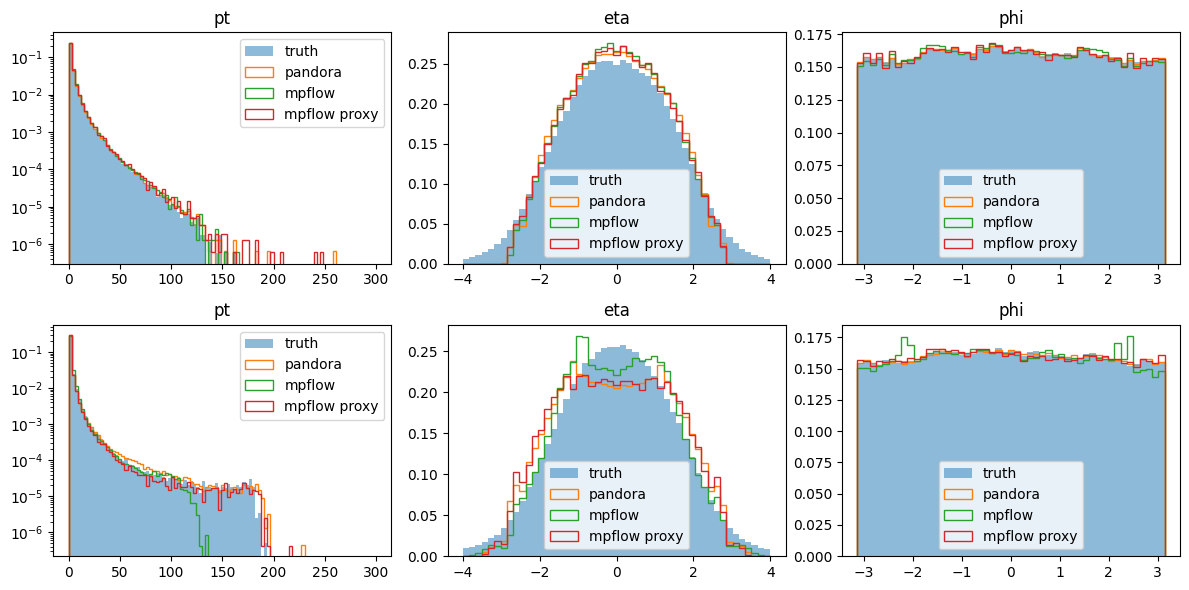

In [ ]:
bins = [
    np.linspace(0, 300, 100),
    np.linspace(-4, 4, 50),
    np.linspace(-np.pi, np.pi, 50),
]
var_names = ["pt", "eta", "phi"]
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
mask_fns = [
    lambda x: x < 3,
    lambda x: (x < 5) & (x > 2),
]
truth_class = np.concatenate(perf_obj.truth_dict["particle_class"])
pandora_class = np.concatenate(perf_obj.truth_dict["pandora_class"])

for i in range(3):
    for j in range(2):
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["particle_" + var_names[i]])[mask_fns[j](truth_class)],
            bins=bins[i],
            histtype="stepfilled",
            alpha=0.5,
            label="truth",
            density=True,
        )
        ax[j, i].hist(
            np.concatenate(perf_obj.truth_dict["pandora_" + var_names[i]])[mask_fns[j](pandora_class)],
            bins=bins[i],
            histtype="step",
            label="pandora",
            density=True,
        )
        for key, value in perf_obj.data.items():
            pf_class = np.concatenate(value["class"])
            ax[j, i].hist(
                np.concatenate(value[var_names[i]])[mask_fns[j](pf_class)],
                bins=bins[i],
                histtype="step",
                label=key,
                density=True,
            )
            if key in {"hgpflow", "mpflow"}:
                ax[j, i].hist(
                    np.concatenate(value["proxy_" + var_names[i]])[mask_fns[j](pf_class)],
                    bins=bins[i],
                    histtype="step",
                    label=key + " proxy",
                    density=True,
                )
        ax[j, i].set_title(var_names[i])
        ax[j, i].legend()
        ax[j, 0].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
def get_n_particles(data_dict, key="class"):
    n_charged = []
    n_neutral = []
    for i in range(len(data_dict[key])):
        ch_mask = data_dict[key][i] <= 2
        n_charged.append(np.sum(ch_mask))
        n_neutral.append(np.sum(~ch_mask))
    return np.array(n_charged), np.array(n_neutral)

In [ ]:
n_charged_truth, n_neutral_truth = get_n_particles(perf_obj.truth_dict, key="particle_class")
n_charged_pandora, n_neutral_pandora = get_n_particles(perf_obj.truth_dict, key="pandora_class")

for key in perf_obj.data.keys():
    n_charged, n_neutral = get_n_particles(perf_obj.data[key])
    perf_obj.data[key]["n_charged"] = n_charged
    perf_obj.data[key]["n_neutral"] = n_neutral

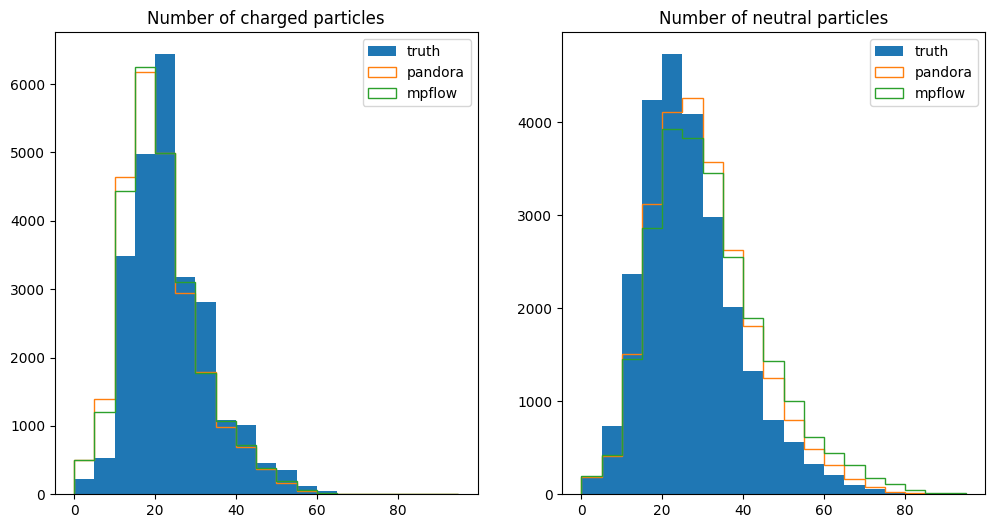

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(n_charged_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[1].hist(n_neutral_truth, bins=np.arange(0, 100, 5), histtype="stepfilled", label="truth")
ax[0].hist(n_charged_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
ax[1].hist(n_neutral_pandora, bins=np.arange(0, 100, 5), histtype="step", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    ax[0].hist(n_charged, bins=np.arange(0, 100, 5), histtype="step", label=key)
    ax[1].hist(n_neutral, bins=np.arange(0, 100, 5), histtype="step", label=key)
ax[0].legend()
ax[1].legend()
ax[0].set_title("Number of charged particles")
ax[1].set_title("Number of neutral particles")
plt.show()

In [ ]:
def _add_hist(ax, data, bins, label, histtype="step", **kwargs):
    mean, iqr_ = np.mean(data), iqr(data)
    label = rf"{label}: $\mu$={mean:.2f}, iqr={iqr_:.2f}"
    ax.hist(data, bins=bins, histtype=histtype, label=label, **kwargs)

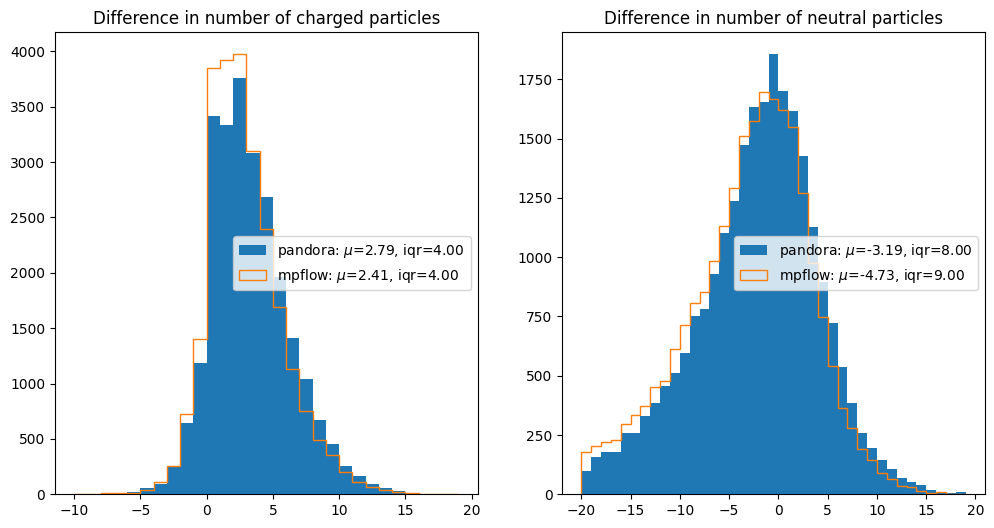

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
_add_hist(ax[0], n_charged_truth - n_charged_pandora, bins=np.arange(-10, 20, 1), histtype="stepfilled", label="pandora")
_add_hist(ax[1], n_neutral_truth - n_neutral_pandora, bins=np.arange(-20, 20, 1), histtype="stepfilled", label="pandora")
for key in perf_obj.data.keys():
    n_charged, n_neutral = perf_obj.data[key]["n_charged"], perf_obj.data[key]["n_neutral"]
    _add_hist(ax[0], n_charged_truth - n_charged, bins=np.arange(-10, 20, 1), label=key, histtype="step")
    _add_hist(ax[1], n_neutral_truth - n_neutral, bins=np.arange(-20, 20, 1), label=key, histtype="step")
ax[0].legend()
ax[1].legend()
ax[0].set_title("Difference in number of charged particles")
ax[1].set_title("Difference in number of neutral particles")
plt.show()

(array([ 369., 1703., 6323., 7128., 4480., 2404., 1265.,  674.,  341.,
          41.]),
 array([  0. ,  13.9,  27.8,  41.7,  55.6,  69.5,  83.4,  97.3, 111.2,
        125.1, 139. ]),
 <BarContainer object of 10 artists>)

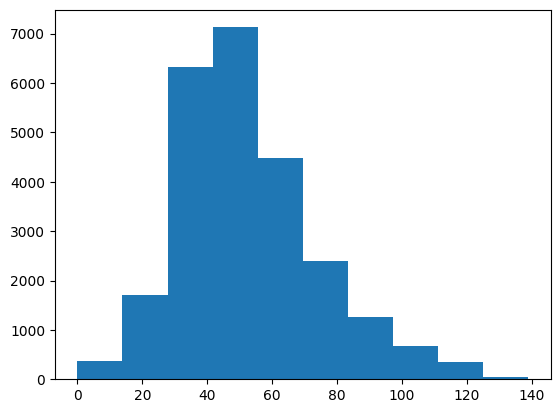

In [ ]:
plt.hist(n_charged + n_neutral)

### Overwrite

- `hgpflow_pt` for neutral particles is better than `proxy_pt`
- But the rest are just worse
- So, I will just overwrite the `hgpflow_xxx` with `proxy_xxx` for the rest

In [ ]:
# perf_obj.data["hgpflow"]["eta"] = perf_obj.data["hgpflow"]["proxy_eta"]
# perf_obj.data["hgpflow"]["phi"] = perf_obj.data["hgpflow"]["proxy_phi"]
# perf_obj.data["hgpflow"]["pt"] = perf_obj.data["hgpflow"]["proxy_pt"]

# for i in range(len(perf_obj.data["hgpflow"]["pt"])):
#     ch_mask = perf_obj.data["hgpflow"]["class"][i] <= 2
#     perf_obj.data["hgpflow"]["pt"][i][ch_mask] = perf_obj.data["hgpflow"]["proxy_pt"][i][ch_mask]

In [ ]:
idx = 0

print("Particle data")
print(np.sort(perf_obj.truth_dict["particle_pt"][idx][perf_obj.truth_dict["particle_class"][idx] <= 2])[::-1])
print("MPflow proxy data")
print(np.sort(perf_obj.data["mpflow"]["proxy_pt"][idx][perf_obj.data["mpflow"]["class"][idx] <= 2])[::-1])
# print("HGPflow proxy data")
# print(np.sort(perf_obj.data['hgpflow']['proxy_pt'][idx][perf_obj.data['hgpflow']['class'][idx] <= 2])[::-1])

Particle data
[22.68040657  9.80447769  4.84874296  3.93368745  3.68394566  3.14503121
  2.60827255  2.39196706  2.09633183  1.96743882  1.35374236  1.34088707
  1.14111745  1.00602424  0.70337182  0.70083827  0.68998379  0.63668203
  0.44614998  0.09880546]
MPflow proxy data
[23.140516    9.781012    4.839227    4.0573926   3.6415377   3.1533294
  2.363066    2.0483649   1.9732016   1.4224751   1.3599572   1.1239315
  1.0143477   0.719316    0.719316    0.719316    0.43903565]


In [ ]:
with uproot.open("/share/gpu1/syw24/dmitrii_clic/test_clic_common_infer.root") as f:
    track_pt = f["EventTree"]["track_pt"].array(library="np")

In [ ]:
track_pt[0]

array([2.0557632 , 2.0023131 , 1.2279536 , 0.9496677 , 0.94607526,
       0.6072147 , 0.57421523, 0.52669734, 0.45971552, 0.45850766,
       0.26150492, 0.14520171, 0.23455974, 0.22790611, 0.183785  ,
       1.2232844 , 0.3203548 , 0.5793999 , 0.5837239 ], dtype=float32)

In [ ]:
perf_obj.compute_jets(n_procs=20)
perf_obj.match_jets()

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7
truth


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|████▊                                                                                                                                | 45/1236 [00:00<00:05, 220.41it/s]

Jet clustering algorithm:  #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#------------------------------------------

Computing jets...:   9%|████████████▏                                                                                                                       | 114/1236 [00:00<00:05, 215.58it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|████▍                                                                                                                                | 41/1237 [00:00<00:05, 210.70it/s]

Computing jets...:  11%|██████████████                                                                                                                      | 132/1236 [00:00<00:03, 276.91it/s]

Jet clustering algorithm:  genkt#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#-------------------------------------

Computing jets...:  19%|████████████████████████▉                                                                                                           | 234/1237 [00:00<00:03, 288.28it/s]

Jet clustering algorithm:  

Computing jets...:   3%|████▏                                                                                                                                | 39/1236 [00:00<00:05, 207.65it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  21%|███████████████████████████▌                                                                                                        | 258/1236 [00:00<00:03, 279.53it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  24%|███████████████████████████████▍                                                                                                    | 295/1237 [00:01<00:03, 293.13it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------

Computing jets...:  23%|██████████████████████████████▏                                                                                                     | 283/1236 [00:01<00:03, 264.08it/s]

Jet clustering algorithm:  

Computing jets...:  31%|████████████████████████████████████████▉                                                                                           | 384/1237 [00:01<00:03, 284.24it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:   0%|                                                                                                                                               | 0/1236 [00:00<?, ?it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:   3%|███▋                                                                                                                                 | 34/1236 [00:00<00:07, 168.52it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  30%|███████████████████████████████████████▏                                                                                            | 367/1237 [00:01<00:03, 267.64it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  14%|█████████████████▉                                                                                                                  | 168/1236 [00:00<00:04, 233.34it/s]

 genkt
Jet clustering radius:  0.7

Computing jets...:  50%|██████████████████████████████████████████████████████████████████▎                                                                 | 621/1236 [00:02<00:02, 266.50it/s]

Computing jets...:   9%|████████████▍                                                                                                                       | 116/1237 [00:00<00:04, 235.53it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  50%|█████████████████████████████████████████████████████████████████▍                                                                  | 613/1237 [00:02<00:02, 257.29it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:   3%|███▉                                                                                                                                 | 37/1237 [00:00<00:06, 192.78it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  57%|███████████████████████████████████████████████████████████████████████████▌                                                        | 708/1236 [00:03<00:02, 233.53it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  15%|███████████████████▌                                                                                                                | 183/1236 [00:00<00:04, 260.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  48%|███████████████████████████████████████████████████████████████                                                                     | 591/1237 [00:02<00:02, 271.52it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#---------------------------------------------------------------------

Computing jets...:  11%|█████████████▉                                                                                                                      | 130/1236 [00:00<00:04, 226.85it/s]

Jet clustering algorithm: 

Computing jets...:   4%|█████▋                                                                                                                               | 53/1236 [00:00<00:06, 180.35it/s]

 #--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
genkt
Jet clustering radius:  0.7


Computing jets...:  42%|███████████████████████████████████████████████████████▉                                                                            | 524/1236 [00:02<00:03, 231.65it/s]

Jet clustering algorithm: 

Computing jets...:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 978/1236 [00:03<00:00, 263.28it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  65%|██████████████████████████████████████████████████████████████████████████████████████▎                                             | 808/1236 [00:03<00:02, 203.17it/s]

Jet clustering algorithm:  

Computing jets...:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 936/1237 [00:03<00:01, 217.58it/s]

genkt


Computing jets...:  37%|████████████████████████████████████████████████▌                                                                                   | 455/1237 [00:01<00:03, 212.35it/s]

Jet clustering radius:  0.7


Computing jets...:  52%|████████████████████████████████████████████████████████████████████▊                                                               | 644/1236 [00:02<00:02, 221.57it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|████▉                                                                                                                                | 46/1236 [00:00<00:07, 151.36it/s]

Jet clustering algorithm: 

Computing jets...:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1157/1236 [00:04<00:00, 181.82it/s]

Computing jets...:  24%|███████████████████████████████▍                                                                                                    | 294/1236 [00:01<00:04, 190.10it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  42%|███████████████████████████████████████████████████████▉                                                                            | 524/1236 [00:02<00:04, 176.91it/s]

Jet clustering algorithm:  genkt

Computing jets...:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1111/1236 [00:04<00:00, 173.98it/s]


Jet clustering radius:  0.7


Computing jets...:  59%|██████████████████████████████████████████████████████████████████████████████▍                                                     | 735/1236 [00:03<00:02, 178.22it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  27%|████████████████████████████████████                                                                                                | 338/1237 [00:02<00:05, 156.26it/s]

Jet clustering algorithm: 

Computing jets...:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 911/1236 [00:04<00:01, 217.57it/s]

 genkt


Computing jets...:  68%|█████████████████████████████████████████████████████████████████████████████████████████                                           | 835/1237 [00:04<00:02, 158.86it/s]

Jet clustering radius:  0.7


Computing jets...:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 961/1236 [00:04<00:01, 217.85it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.5.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:05<00:00, 228.64it/s]


pandora
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|█████▏                                                                                                                               | 48/1236 [00:00<00:04, 240.11it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  20%|██████████████████████████                                                                                                          | 244/1236 [00:00<00:03, 262.69it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  20%|██████████████████████████▏                                                                                                         | 245/1236 [00:00<00:03, 291.83it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|█████████▎                                                                                                                           | 87/1236 [00:00<00:03, 293.69it/s]

Jet clustering algorithm:  

Computing jets...:  14%|██████████████████▏                                                                                                                 | 171/1237 [00:00<00:03, 289.03it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  19%|█████████████████████████▎                                                                                                          | 237/1237 [00:00<00:03, 293.87it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  43%|████████████████████████████████████████████████████████▎                                                                           | 527/1236 [00:02<00:02, 272.23it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  13%|████████████████▉                                                                                                                   | 159/1237 [00:00<00:05, 202.61it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  53%|█████████████████████████████████████████████████████████████████████▎                                                              | 649/1236 [00:02<00:02, 271.97it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  39%|███████████████████████████████████████████████████                                                                                 | 478/1237 [00:01<00:02, 260.79it/s]

Computing jets...:  16%|█████████████████████▎                                                                                                              | 199/1236 [00:00<00:04, 241.08it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  28%|█████████████████████████████████████▏                                                                                              | 348/1237 [00:01<00:04, 216.76it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  45%|███████████████████████████████████████████████████████████▋                                                                        | 559/1236 [00:02<00:02, 249.05it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 954/1236 [00:03<00:01, 238.32it/s]

Jet clustering algorithm:  genkt


Computing jets...:  27%|███████████████████████████████████▌                                                                                                | 333/1237 [00:01<00:03, 237.91it/s]

Jet clustering radius: 

Computing jets...:   9%|████████████▎                                                                                                                       | 115/1236 [00:00<00:04, 225.80it/s]

 0.7


Computing jets...:  40%|█████████████████████████████████████████████████████▏                                                                              | 498/1236 [00:02<00:03, 241.27it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1094/1236 [00:04<00:00, 194.89it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1076/1236 [00:04<00:00, 178.31it/s]

0.7


Computing jets...:   9%|████████████▎                                                                                                                       | 115/1237 [00:00<00:06, 176.56it/s]

Jet clustering algorithm:  genkt


Computing jets...:  34%|████████████████████████████████████████████▋                                                                                       | 419/1236 [00:01<00:03, 204.44it/s]

Jet clustering radius:  0.7


Computing jets...:  57%|██████████████████████████████████████████████████████████████████████████▋                                                         | 700/1237 [00:03<00:03, 175.33it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1169/1237 [00:04<00:00, 207.70it/s]

Jet clustering algorithm: 

Computing jets...:  51%|███████████████████████████████████████████████████████████████████                                                                 | 628/1237 [00:03<00:03, 163.30it/s]

 genkt
Jet clustering radius:  

Computing jets...:  69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                         | 847/1236 [00:03<00:01, 195.09it/s]

0.7


Computing jets...:  13%|█████████████████▌                                                                                                                  | 164/1236 [00:01<00:06, 168.47it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  

Computing jets...:  33%|███████████████████████████████████████████▎                                                                                        | 406/1236 [00:02<00:03, 214.05it/s]

0.7


Computing jets...:  27%|███████████████████████████████████▌                                                                                                | 333/1237 [00:01<00:05, 176.67it/s]

Jet clustering algorithm:  

Computing jets...:  60%|███████████████████████████████████████████████████████████████████████████████▎                                                    | 743/1236 [00:03<00:02, 186.65it/s]

genkt

Computing jets...:  42%|███████████████████████████████████████████████████████▍                                                                            | 520/1237 [00:02<00:04, 155.68it/s]


Jet clustering radius:  0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1237/1237 [00:05<00:00, 242.86it/s]


mpflow jets
Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|████▏                                                                                                                                | 39/1236 [00:00<00:06, 189.94it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  11%|███████████████▏                                                                                                                    | 142/1236 [00:00<00:04, 220.51it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  21%|███████████████████████████▎                                                                                                        | 256/1236 [00:01<00:04, 237.34it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|███▉                                                                                                                                 | 37/1236 [00:00<00:06, 185.38it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  29%|██████████████████████████████████████▏                                                                                             | 358/1236 [00:01<00:03, 229.68it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|███▍                                                                                                                                 | 32/1236 [00:00<00:07, 162.19it/s]

Jet clustering algorithm: 

Computing jets...:  33%|███████████████████████████████████████████▎                                                                                        | 406/1236 [00:01<00:03, 226.68it/s]

 genkt
Jet clustering radius:  

Computing jets...:   6%|████████▎                                                                                                                            | 77/1237 [00:00<00:06, 187.79it/s]

0.7


Computing jets...:   3%|███▉                                                                                                                                 | 37/1236 [00:00<00:06, 181.96it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|████▎                                                                                                                                | 40/1237 [00:00<00:06, 192.54it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   7%|████████▋                                                                                                                            | 81/1237 [00:00<00:06, 188.86it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|████                                                                                                                                 | 38/1237 [00:00<00:06, 185.38it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|██████████▉                                                                                                                         | 102/1237 [00:00<00:06, 187.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  32%|█████████████████████████████████████████▉                                                                                          | 393/1237 [00:01<00:03, 216.28it/s]

Jet clustering algorithm: 

Computing jets...:  14%|█████████████████▊                                                                                                                  | 167/1237 [00:00<00:05, 205.33it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  13%|█████████████████▍                                                                                                                  | 163/1236 [00:00<00:05, 187.65it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  28%|█████████████████████████████████████                                                                                               | 347/1236 [00:01<00:04, 201.97it/s]

 0.7


Computing jets...:  36%|███████████████████████████████████████████████▏                                                                                    | 442/1236 [00:02<00:04, 198.11it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  42%|███████████████████████████████████████████████████████▏                                                                            | 517/1236 [00:02<00:04, 152.31it/s]

Computing jets...:  69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                        | 855/1236 [00:04<00:02, 181.67it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  25%|████████████████████████████████▎                                                                                                   | 303/1236 [00:01<00:06, 142.55it/s]

Computing jets...:  24%|███████████████████████████████▊                                                                                                    | 298/1237 [00:01<00:05, 175.38it/s]

0.7


Computing jets...:  23%|██████████████████████████████▌                                                                                                     | 286/1236 [00:01<00:04, 193.95it/s]

Jet clustering algorithm:  genkt


Computing jets...:  49%|█████████████████████████████████████████████████████████████████                                                                   | 610/1237 [00:03<00:05, 118.38it/s]

Jet clustering radius:  0.7


Computing jets...:  48%|██████████████████████████████████████████████████████████████▉                                                                     | 590/1237 [00:03<00:04, 143.18it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  49%|████████████████████████████████████████████████████████████████▋                                                                   | 606/1236 [00:03<00:04, 143.90it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  62%|██████████████████████████████████████████████████████████████████████████████████▍                                                 | 772/1236 [00:04<00:03, 136.46it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:07<00:00, 161.16it/s]


Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   3%|████▏                                                                                                                                | 39/1236 [00:00<00:06, 188.55it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   8%|██████████▌                                                                                                                          | 98/1236 [00:00<00:06, 170.95it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   2%|██▋                                                                                                                                  | 25/1237 [00:00<00:10, 120.95it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   6%|████████▏                                                                                                                            | 76/1237 [00:00<00:05, 200.90it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  19%|████████████████████████▉                                                                                                           | 234/1236 [00:01<00:04, 204.42it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  19%|████████████████████████▍                                                                                                           | 229/1237 [00:01<00:04, 201.81it/s]

Jet clustering algorithm: 

Computing jets...:  17%|██████████████████████▉                                                                                                             | 215/1236 [00:00<00:04, 220.95it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  21%|████████████████████████████                                                                                                        | 263/1236 [00:01<00:04, 223.59it/s]

Jet clustering algorithm: 

Computing jets...:   3%|███▋                                                                                                                                 | 34/1236 [00:00<00:07, 166.31it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:   6%|████████                                                                                                                             | 75/1236 [00:00<00:06, 188.99it/s]

Jet clustering algorithm:  

Computing jets...:  25%|█████████████████████████████████                                                                                                   | 309/1236 [00:01<00:04, 218.32it/s]

genkt
Jet clustering radius: 

Computing jets...:  17%|██████████████████████▋                                                                                                             | 213/1237 [00:01<00:05, 182.27it/s]

 0.7


Computing jets...:  11%|██████████████▎                                                                                                                     | 134/1236 [00:00<00:05, 190.88it/s]

Jet clustering algorithm:  genkt

Computing jets...:  23%|██████████████████████████████▎                                                                                                     | 284/1237 [00:01<00:04, 212.34it/s]

Computing jets...:   5%|███████                                                                                                                              | 66/1236 [00:00<00:05, 216.26it/s]

Jet clustering radius:  0.7


Computing jets...:  12%|███████████████▉                                                                                                                    | 149/1237 [00:00<00:05, 186.17it/s]

Jet clustering algorithm: 

Computing jets...:  28%|█████████████████████████████████████▎                                                                                              | 350/1237 [00:01<00:04, 204.55it/s]

 genkt
Jet clustering radius:  0.7


Computing jets...:  33%|██████████████████████████████████████████▉                                                                                         | 402/1236 [00:01<00:03, 222.61it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  54%|███████████████████████████████████████████████████████████████████████▏                                                            | 667/1236 [00:03<00:02, 205.16it/s]

Jet clustering algorithm:  genkt

Computing jets...:  38%|██████████████████████████████████████████████████▏                                                                                 | 470/1236 [00:02<00:03, 213.12it/s]

Computing jets...:   5%|██████▏                                                                                                                              | 58/1236 [00:00<00:05, 199.09it/s]

Jet clustering radius:  0.7


Computing jets...:   3%|███▍                                                                                                                                 | 32/1237 [00:00<00:07, 164.16it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:  34%|█████████████████████████████████████████████▏                                                                                      | 423/1236 [00:02<00:04, 201.37it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7


Computing jets...:   4%|████▊                                                                                                                                | 45/1237 [00:00<00:07, 156.28it/s]

Jet clustering algorithm:  

Computing jets...:  39%|███████████████████████████████████████████████████▊                                                                                | 485/1236 [00:02<00:03, 191.92it/s]

genkt
Jet clustering radius:  0.7

Computing jets...:  65%|█████████████████████████████████████████████████████████████████████████████████████▊                                              | 803/1236 [00:03<00:02, 150.64it/s]

Computing jets...:  30%|███████████████████████████████████████▌                                                                                            | 370/1236 [00:01<00:03, 237.69it/s]

Jet clustering algorithm: 

Computing jets...:  21%|███████████████████████████▊                                                                                                        | 261/1236 [00:01<00:05, 170.67it/s]

Computing jets...:  32%|█████████████████████████████████████████▊                                                                                          | 392/1236 [00:02<00:05, 162.62it/s]

genkt
Jet clustering radius:  0.7


Computing jets...:  64%|████████████████████████████████████████████████████████████████████████████████████▎                                               | 789/1236 [00:04<00:02, 153.81it/s]

Jet clustering algorithm:  genkt
Jet clustering radius:  0.7

Computing jets...:  72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 884/1236 [00:04<00:01, 183.79it/s]

Computing jets...:  17%|██████████████████████▋                                                                                                             | 212/1236 [00:01<00:04, 226.30it/s]

Jet clustering algorithm:  genkt


Computing jets...:   7%|█████████▍                                                                                                                           | 88/1236 [00:00<00:09, 119.77it/s]

Jet clustering radius:  0.7


Computing jets...:  43%|█████████████████████████████████████████████████████████▏                                                                          | 535/1236 [00:03<00:05, 129.19it/s]

Jet clustering algorithm:  genkt
Jet clustering radius: 

Computing jets...:  27%|███████████████████████████████████                                                                                                 | 328/1236 [00:01<00:05, 161.18it/s]

Computing jets...:  62%|█████████████████████████████████████████████████████████████████████████████████▉                                                  | 767/1236 [00:04<00:04, 115.17it/s]

0.7


Matching jets...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:00<00:00, 31352.10it/s]


Process ForkPoolWorker-13:
Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-18:
Process ForkPoolWorker-9:
Process ForkPoolWorker-19:
Process ForkPoolWorker-12:
Process ForkPoolWorker-16:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Process ForkPoolWorker-17:
Process ForkPoolWorker-5:
Process ForkPoolWorker-10:
Process ForkPoolWorker-20:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Process ForkPoolWorker-7:
Process ForkPoolWorker-11:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

### Jet residual plots

In [ ]:
_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['matched_mlpf_jets'],
    "mpflow": perf_obj.data["mpflow"]["matched_jets"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["matched_proxy_jets"],
    # 'hgpflow_target': perf_obj.data['hgpflow_target']['matched_jets'],
}

jet_residual_dict = compute_jet_residual_dict(_dict, dr_cut=0.1, leading_N_jets=2, pt_min=10)

/tmp/ipykernel_35356/2474152153.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout()


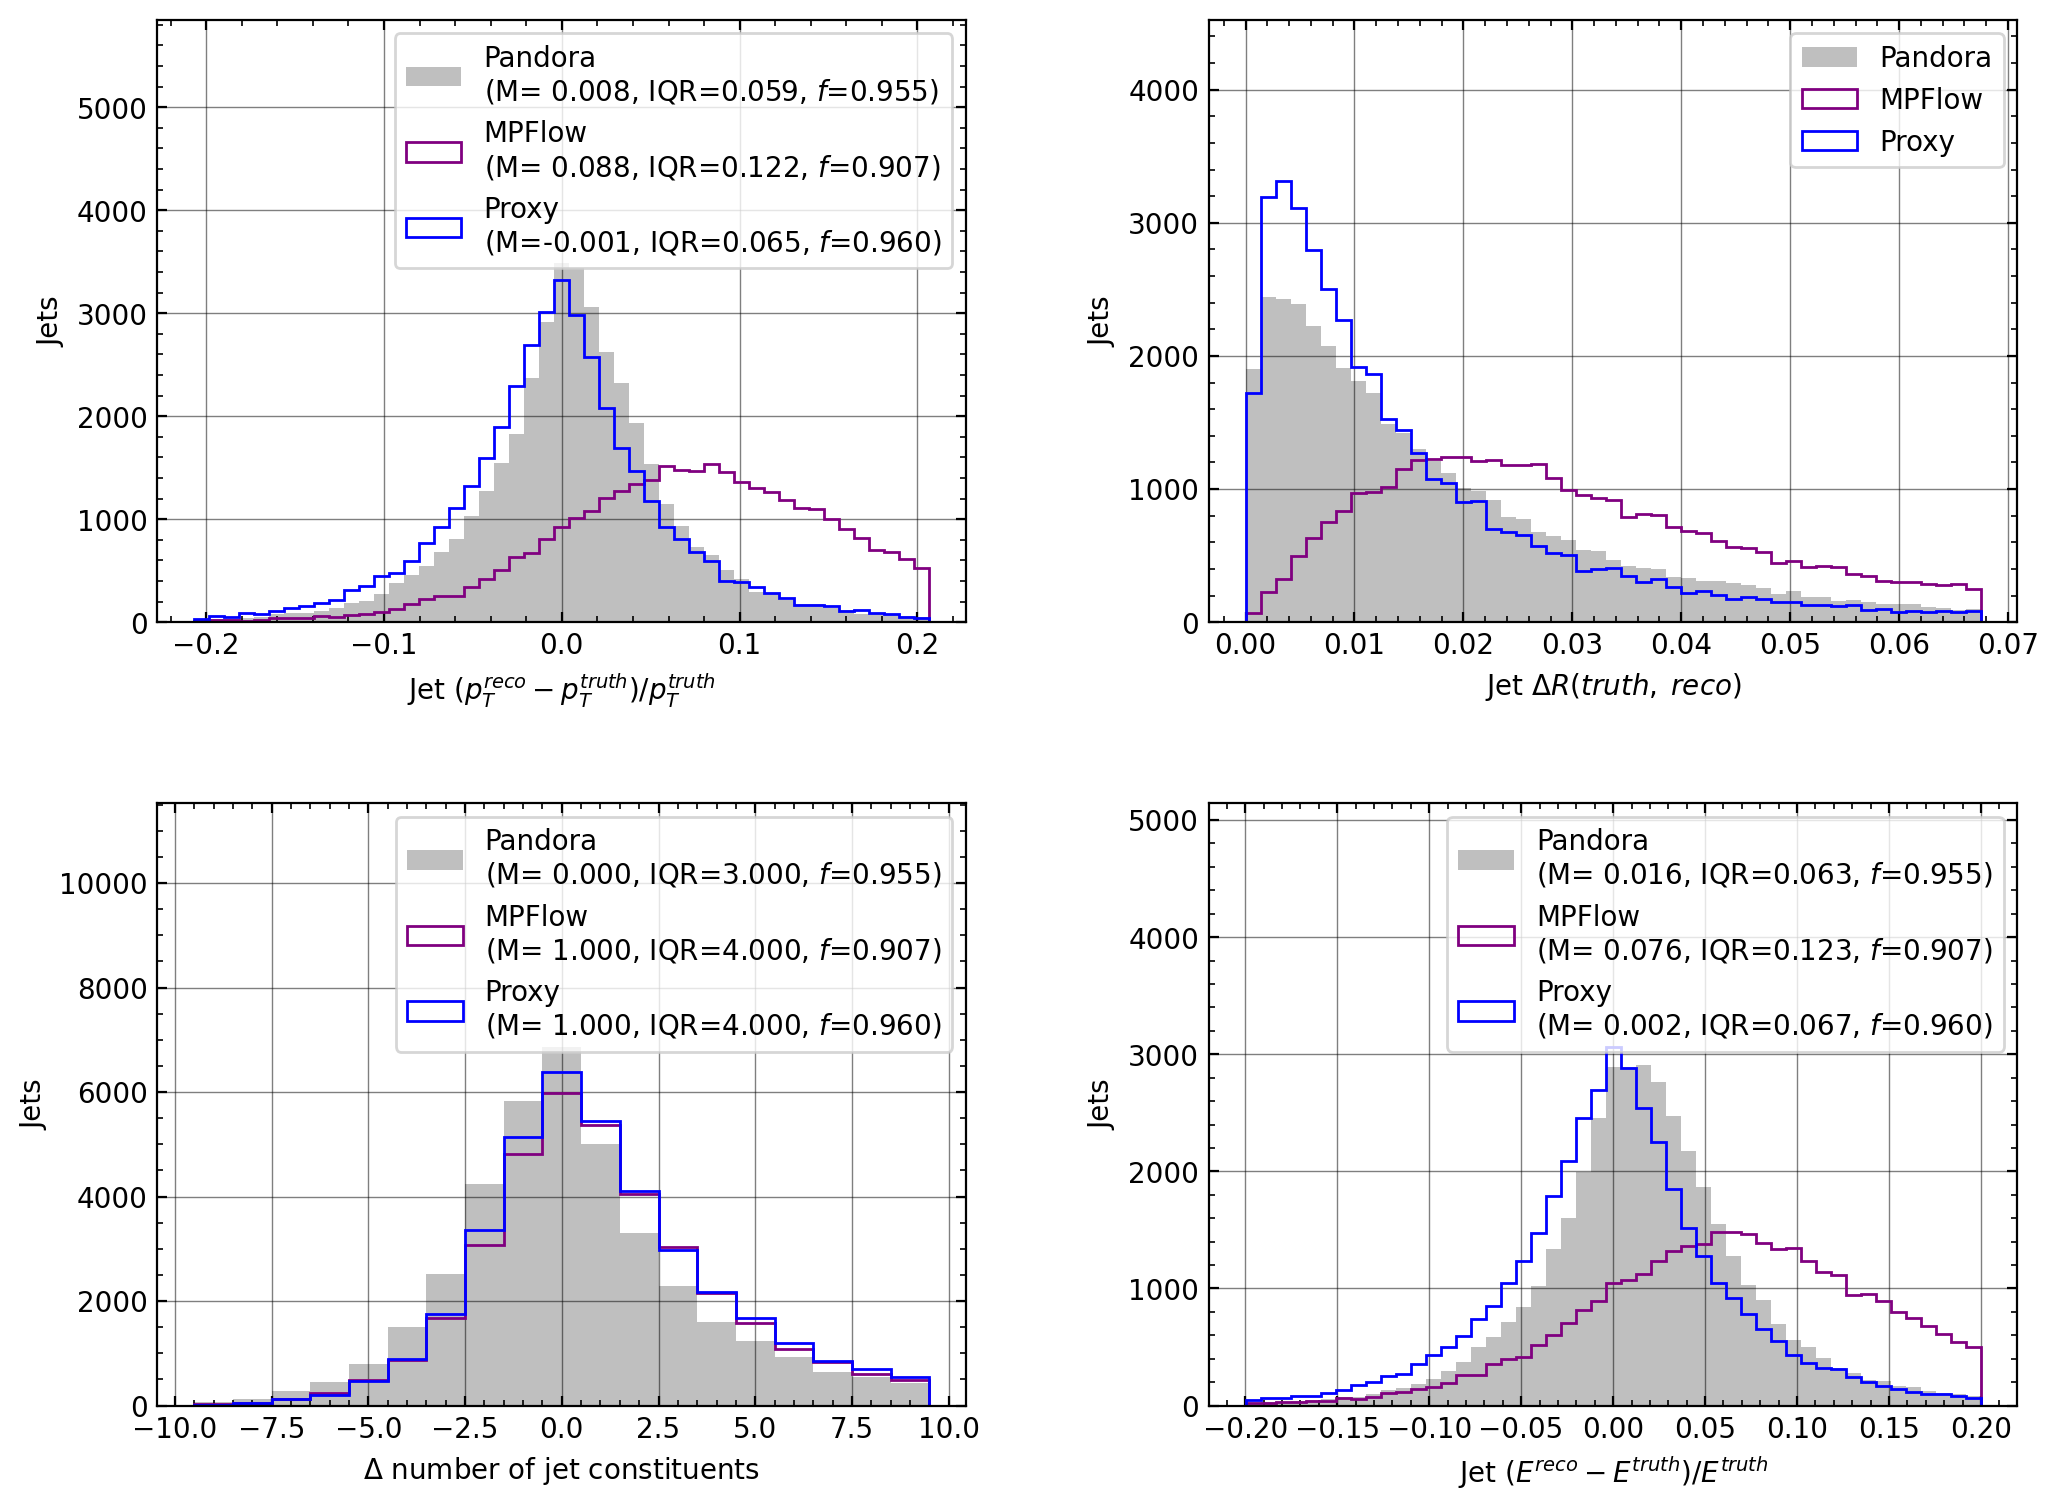

In [ ]:
# change the x_lims

figs = plot_jet_residuals(jet_residual_dict, pt_relative=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/clic_dijet_jet_residuals_pt.png", dpi=300)
        figs[1].savefig(f"{save_dir}/clic_dijet_jet_residuals_dr.png", dpi=300)
        figs[2].savefig(f"{save_dir}/clic_dijet_jet_residuals_constcount.png", dpi=300)
        figs[3].savefig(f"{save_dir}/clic_dijet_jet_residuals_e.png", dpi=300)
    else:
        figs.tight_layout()
        figs.savefig(f"{save_dir}/clic_dijet_jet_residuals.png", dpi=300, bbox_inches="tight")

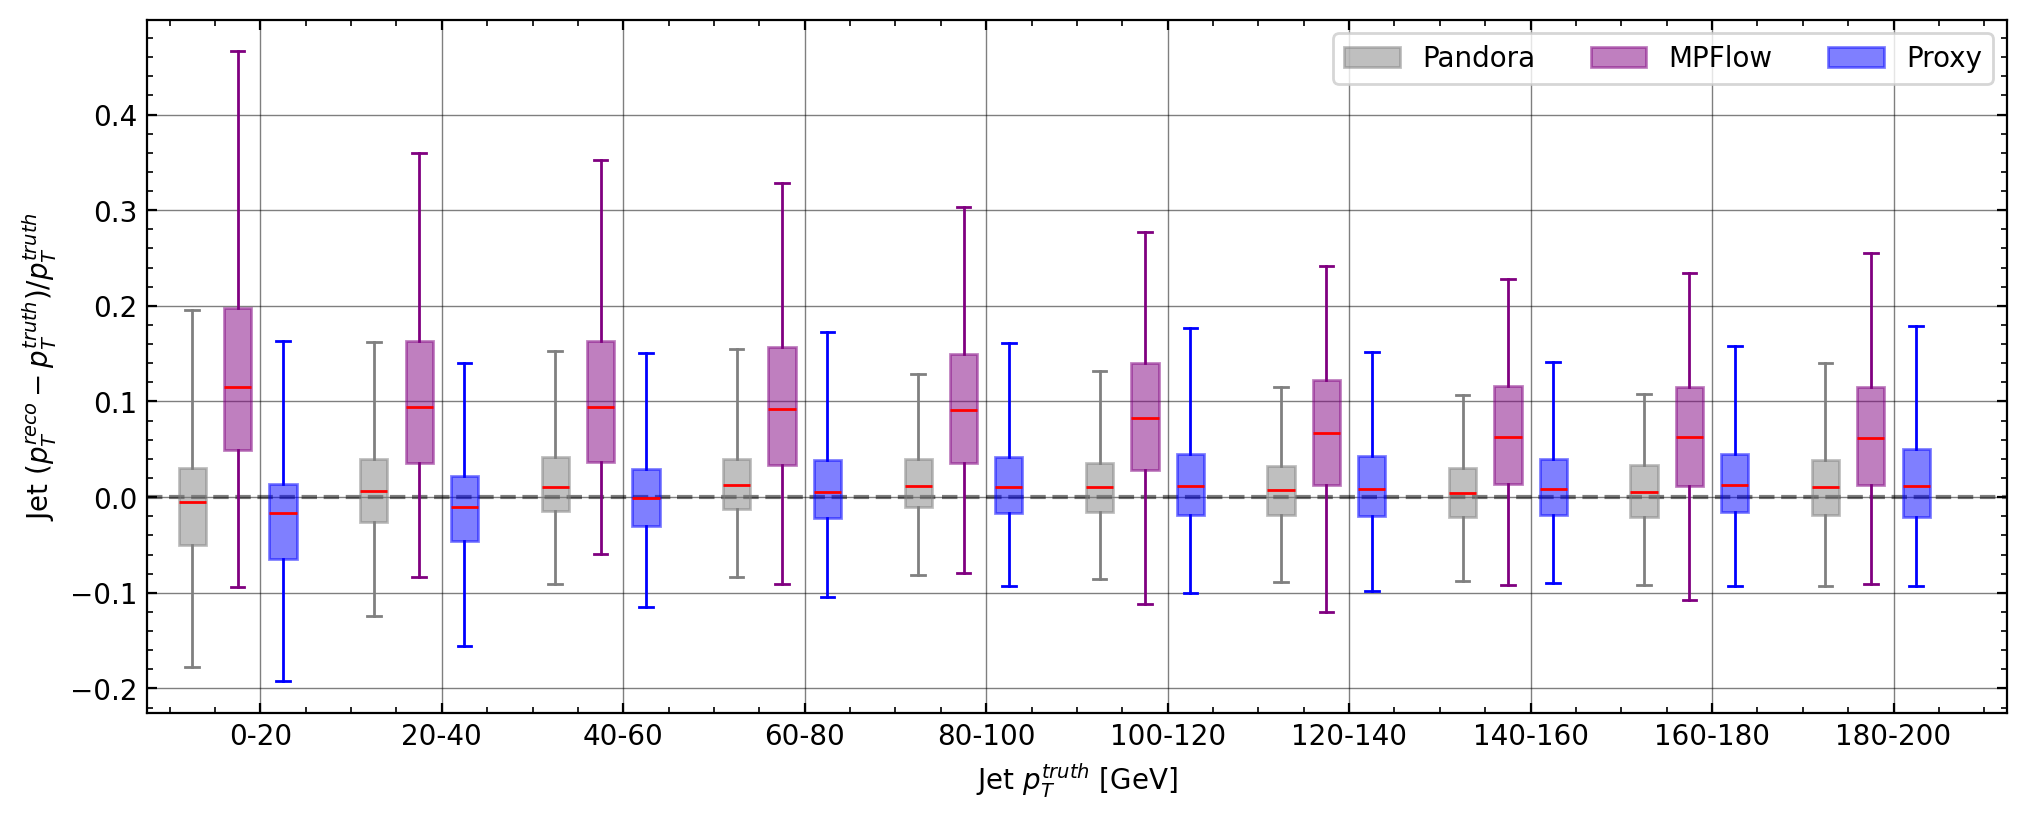

In [ ]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_res_boxplot(jet_residual_dict, bins=pt_bins, var="pt")
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_residuals_boxplot_pt.png", dpi=300)

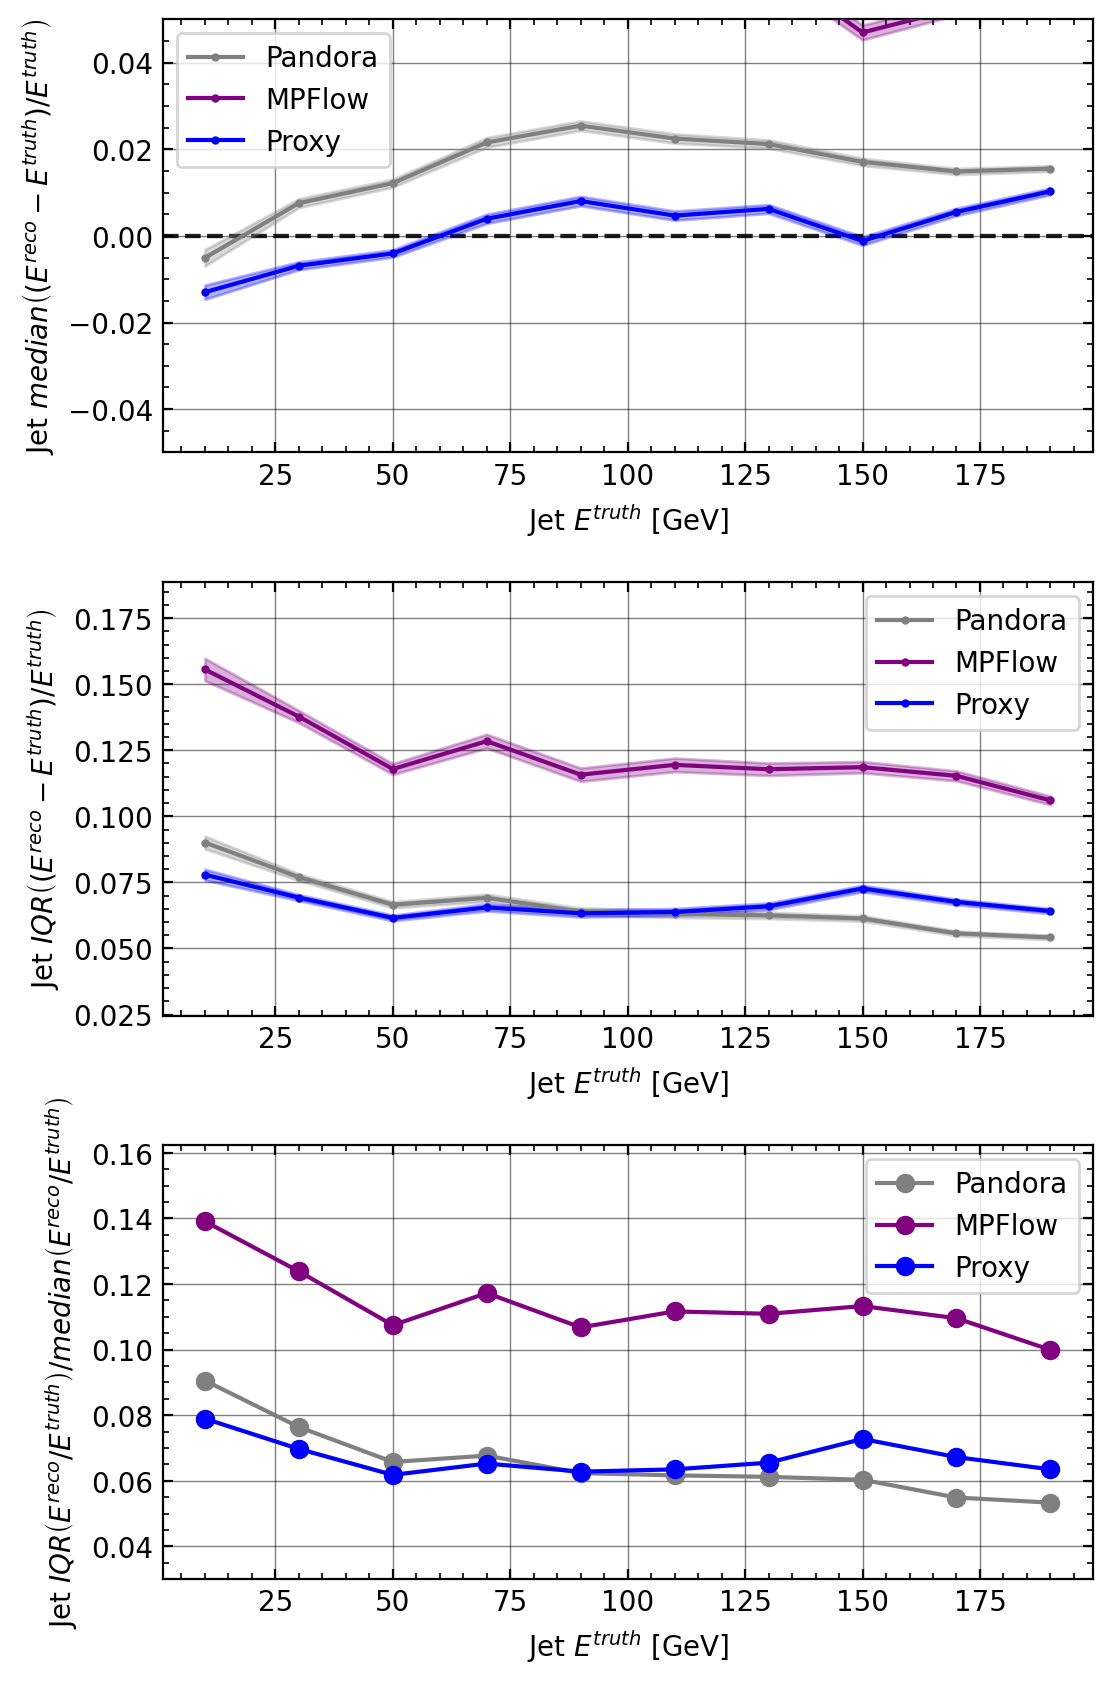

In [ ]:
pt_bins = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
fig = plot_jet_response(jet_residual_dict, pt_bins=pt_bins, use_energy=True, separate_figures=False)
if SAVE_FIG:
    if isinstance(fig, list):
        for i, f in enumerate(fig):
            f.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot_{i}.png", dpi=300)
    else:
        fig.savefig(f"{save_dir}/clic_dijet_jet_response_boxplot.png", dpi=300, bbox_inches="tight")

### jet marginal distributions

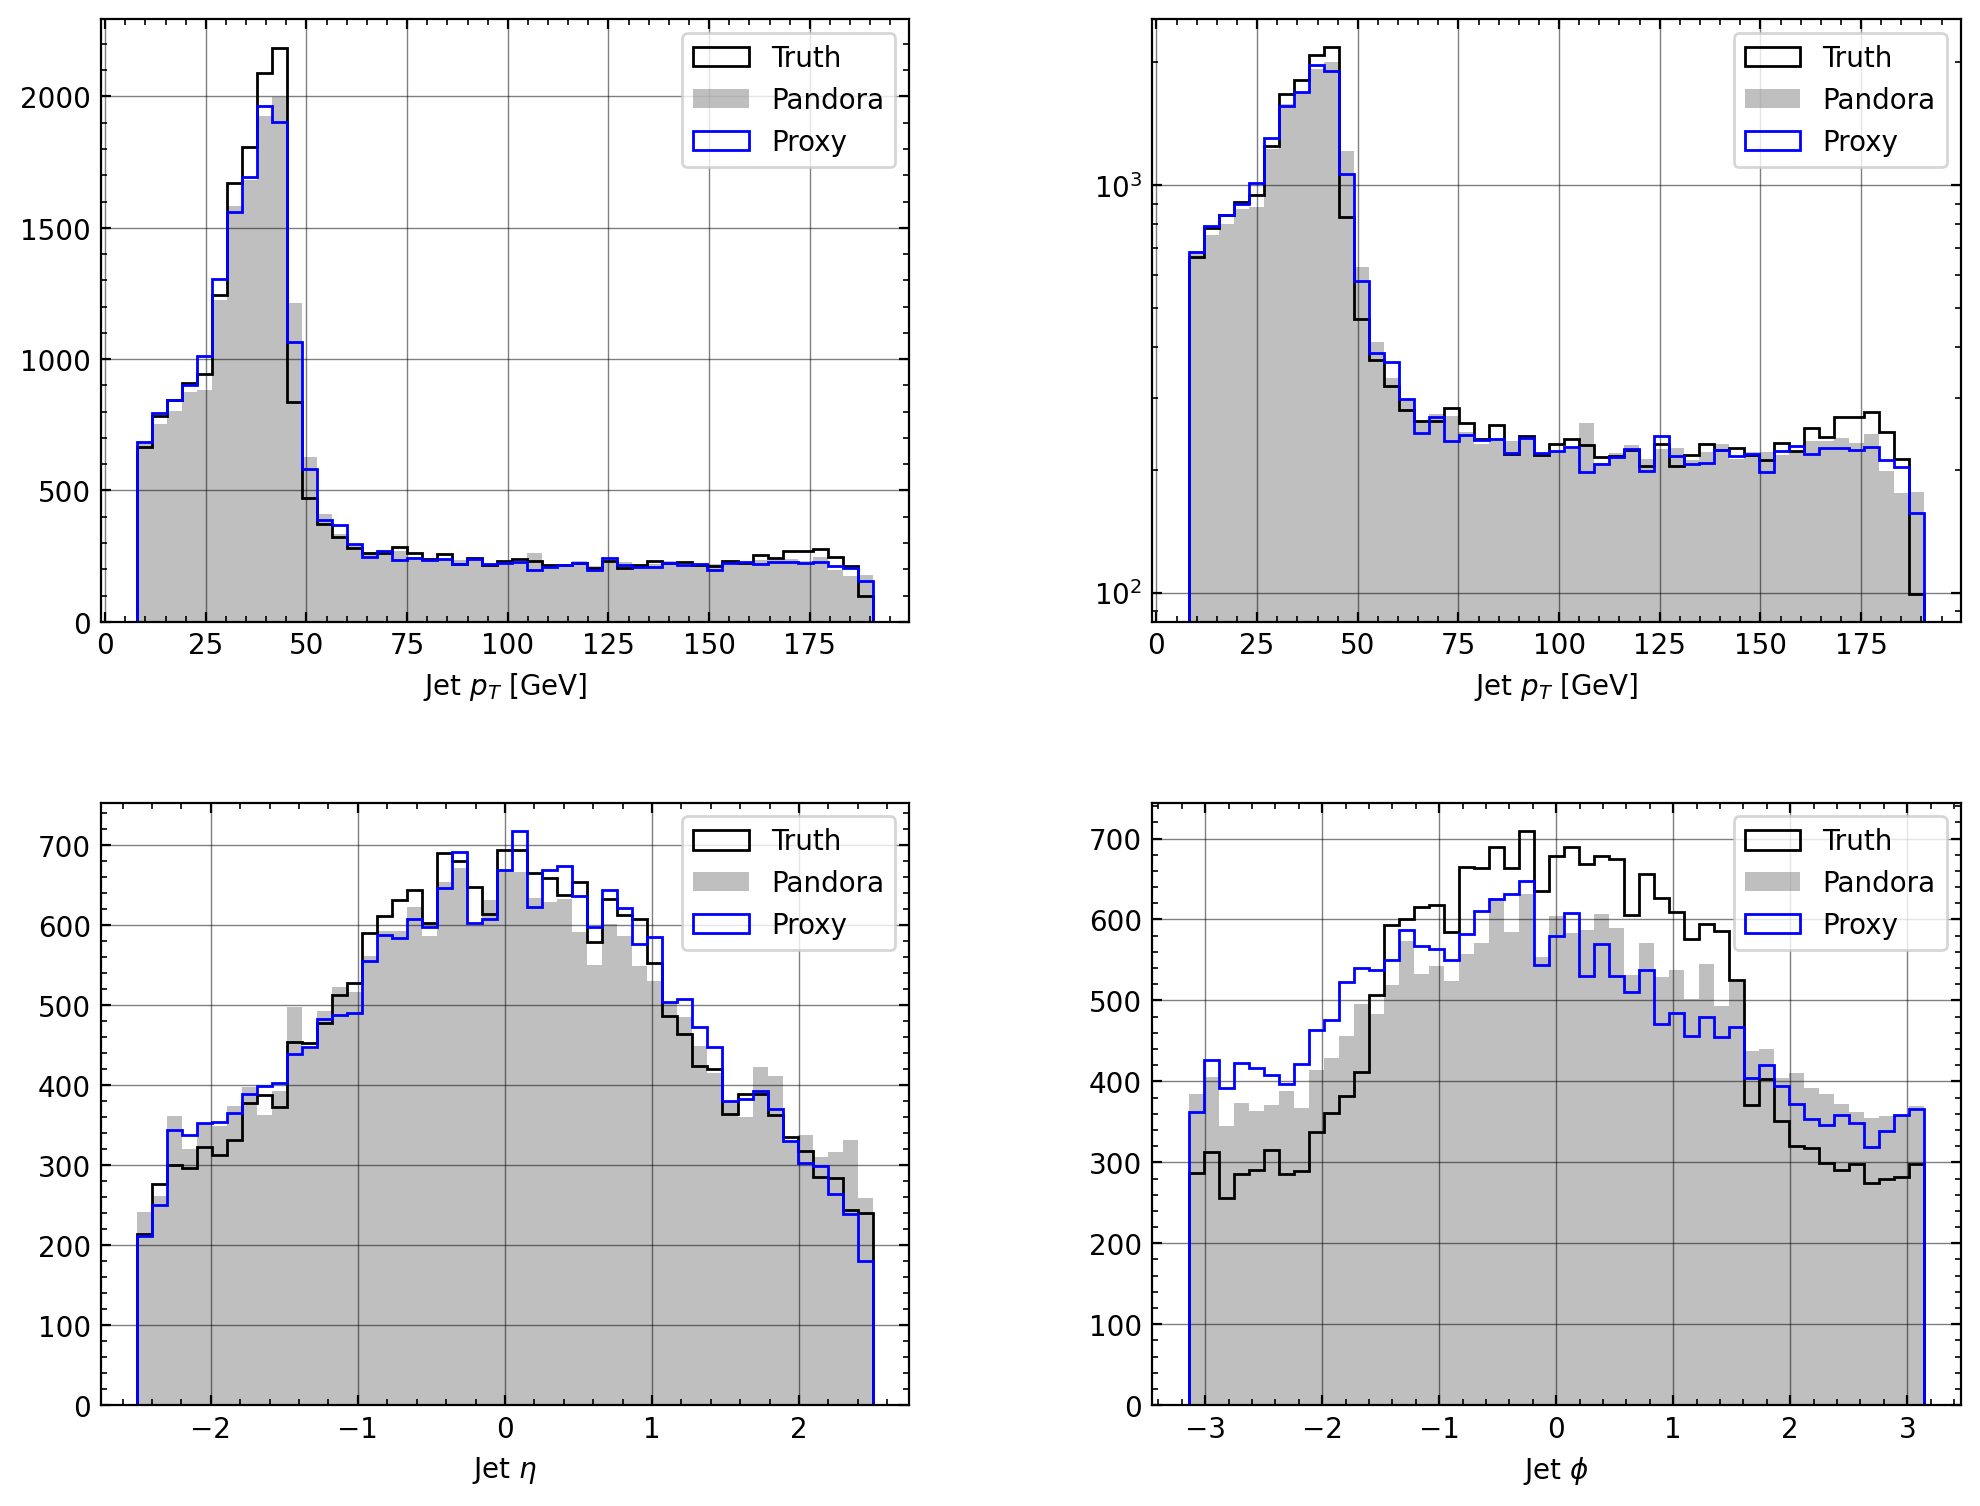

In [ ]:
jet_dict = {
    "truth": perf_obj.truth_dict["truth_jets"],
    "pandora": perf_obj.truth_dict["pandora_jets"],
    # 'mlpf': perf_obj.mlpf_dict['jets'],
    # "mpflow": perf_obj.data["mpflow"]["jets"],
    "proxy": perf_obj.data["mpflow"]["proxy_jets"],
    # "hgpflow": perf_obj.data["hgpflow"]["jets"],
}

fig = plot_jet_marginals(jet_dict, nleading=1, stylesheet=None)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/clic_dijet_jet_marginals.png", dpi=300, bbox_inches="tight")

## Particle performance

In [ ]:
perf_obj.hung_match_particles(flatten=True, return_unmatched=True)

Matching particles...:   0%|                                                                                                                                          | 0/24728 [00:00<?, ?it/s]

Matching particles...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:05<00:00, 4131.54it/s]


In [ ]:
style_sheet_eff_fr = {
    "LINE_STYLES": {
        "proxy": "-",
        "mpflow": "-.",
        "pandora": "--",
    },
    "COLORS": {
        "proxy": {
            "neut had": "mediumseagreen",
            "photon": "tomato",
        },
        "mpflow": {
            "neut had": "orange",
            "photon": "darkorchid",
        },
        "pandora": {
            "neut had": "dodgerblue",
            "photon": "goldenrod",
        },
    },
}

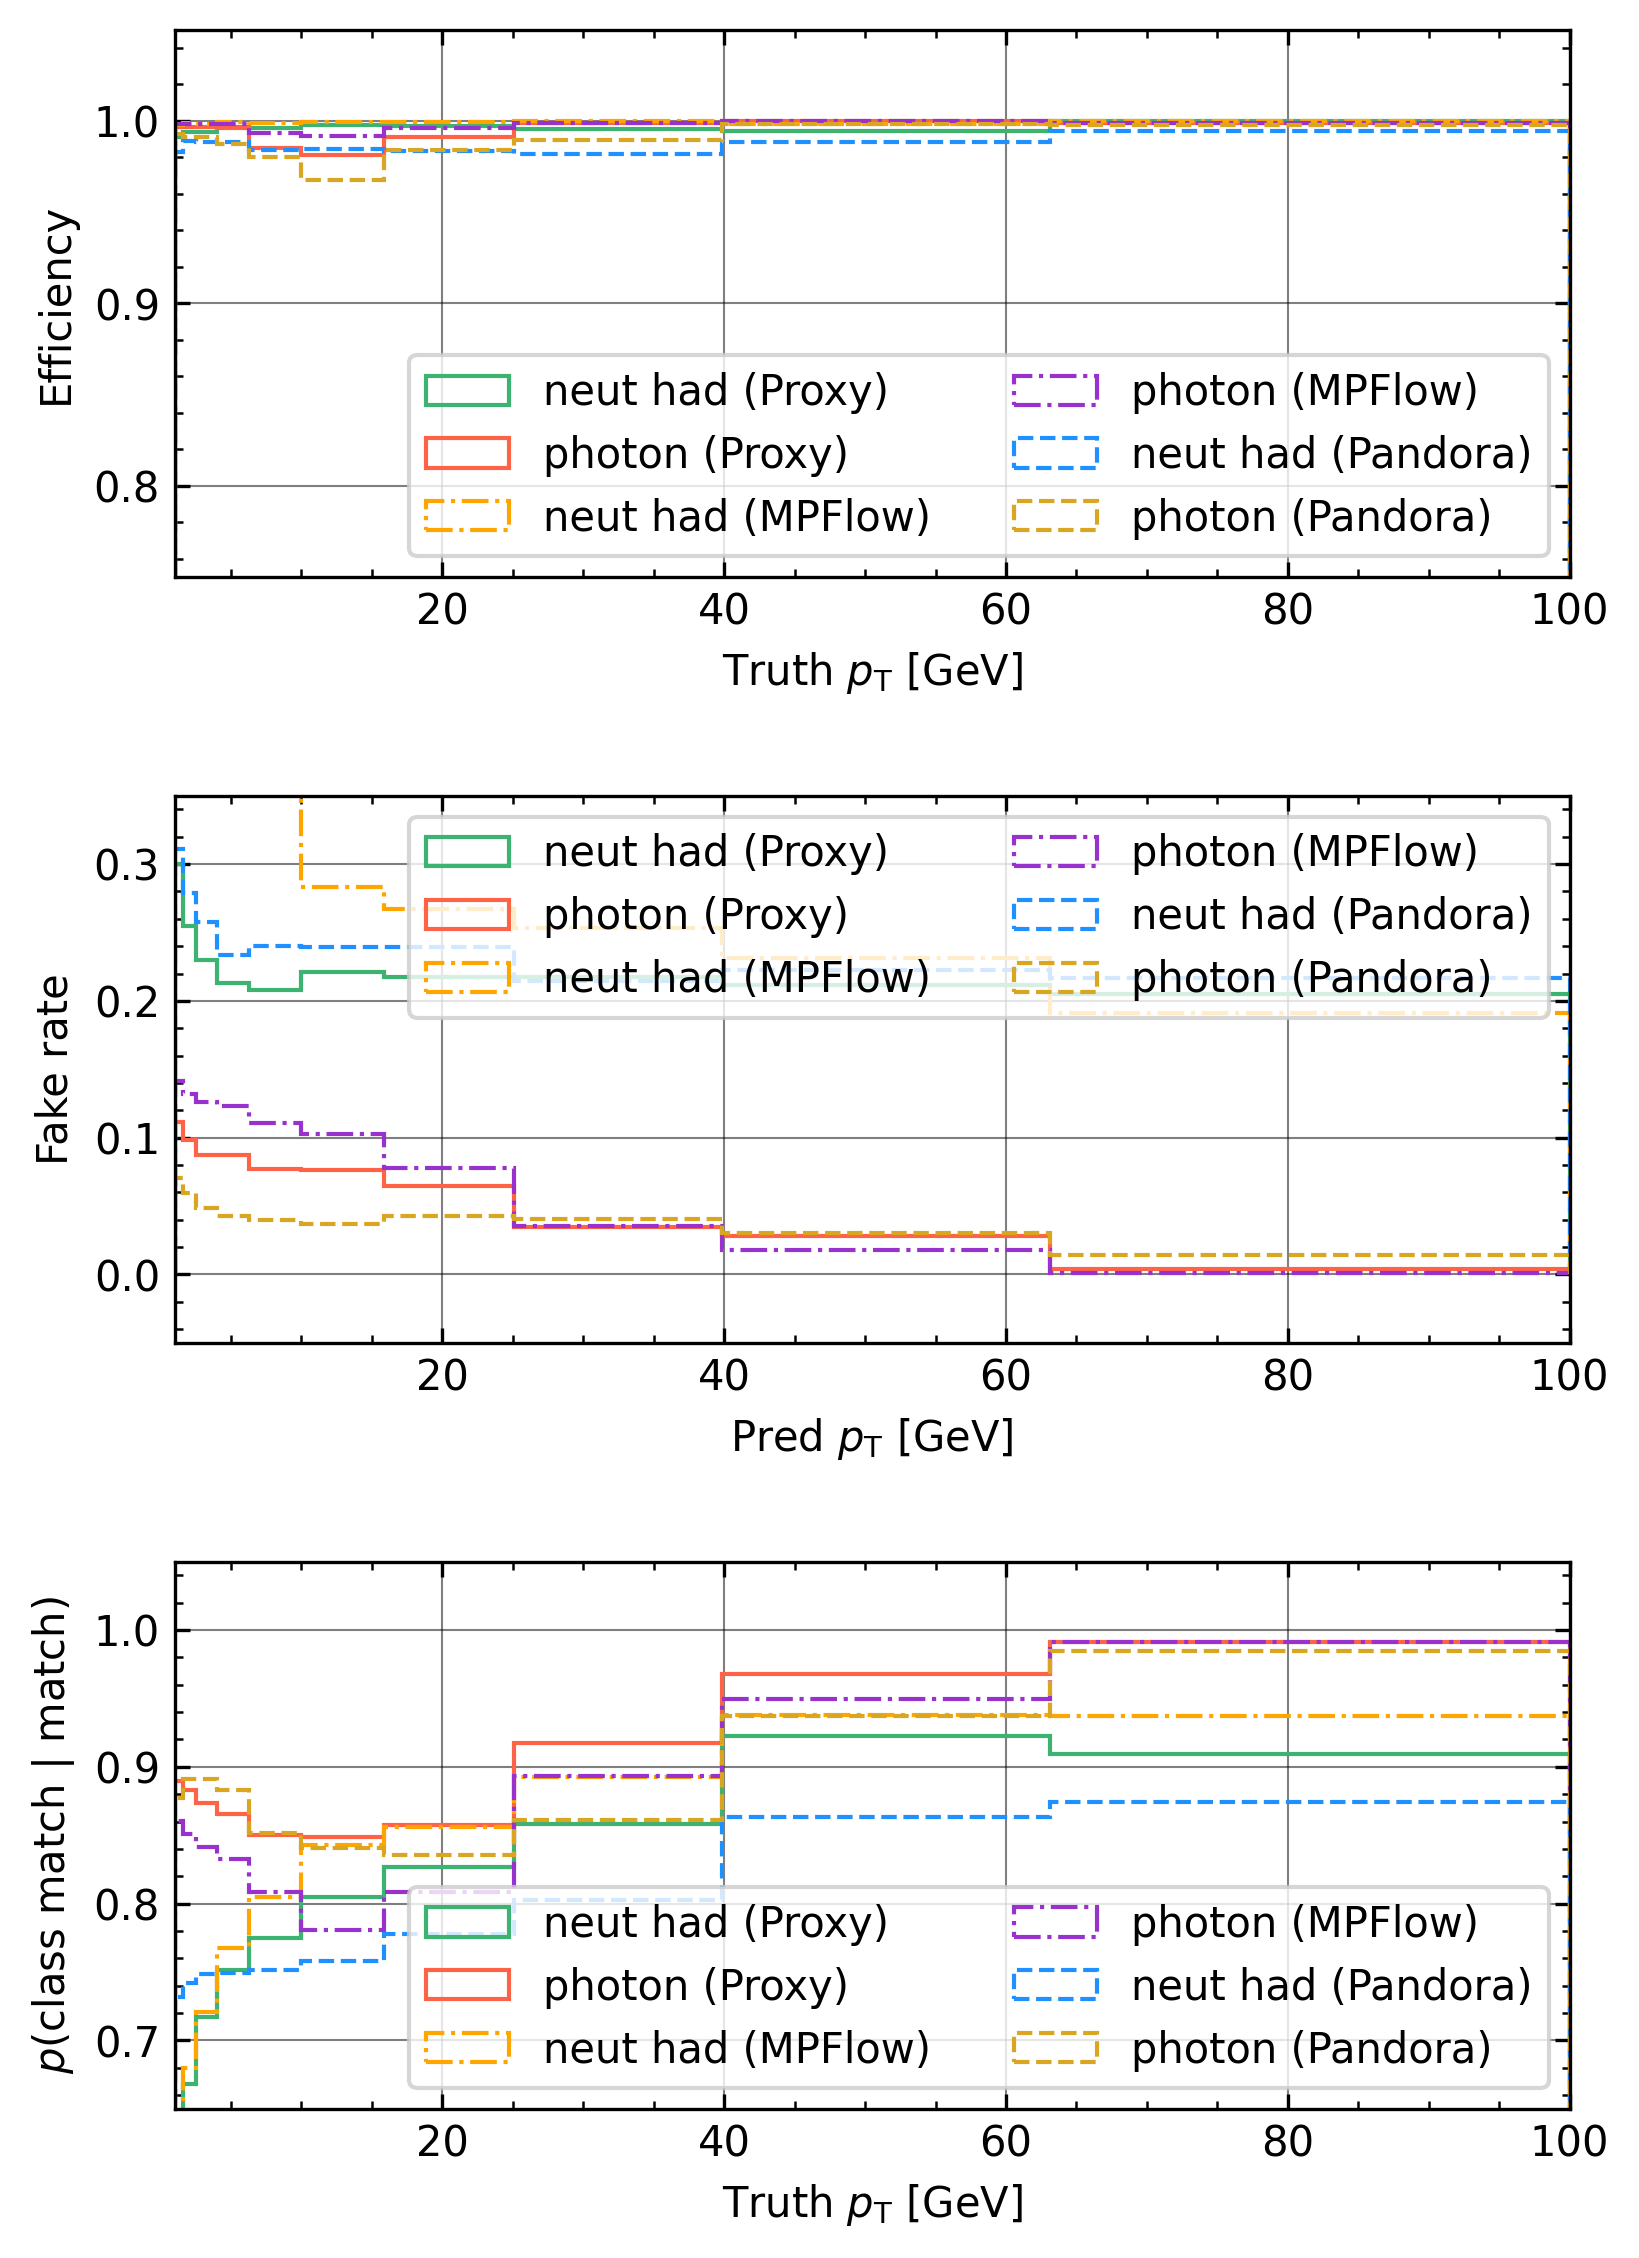

In [ ]:
eff_fr_purity_input_dict = {
    "proxy": {
        "ref_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_proxy_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_proxy_particles"][3],
    },
    "mpflow": {
        "ref_matched": perf_obj.data["mpflow"]["matched_particles"][0],
        "comp_matched": perf_obj.data["mpflow"]["matched_particles"][1],
        "ref_unmatched": perf_obj.data["mpflow"]["matched_particles"][2],
        "comp_unmatched": perf_obj.data["mpflow"]["matched_particles"][3],
    },
    "pandora": {
        "ref_matched": perf_obj.truth_dict["matched_pandora_particles"][0],
        "comp_matched": perf_obj.truth_dict["matched_pandora_particles"][1],
        "ref_unmatched": perf_obj.truth_dict["matched_pandora_particles"][2],
        "comp_unmatched": perf_obj.truth_dict["matched_pandora_particles"][3],
    },
}

fig = plot_eff_fr_purity(eff_fr_purity_input_dict, stylesheet=style_sheet_eff_fr)
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_eff_fr_purity.png", dpi=300, bbox_inches="tight")

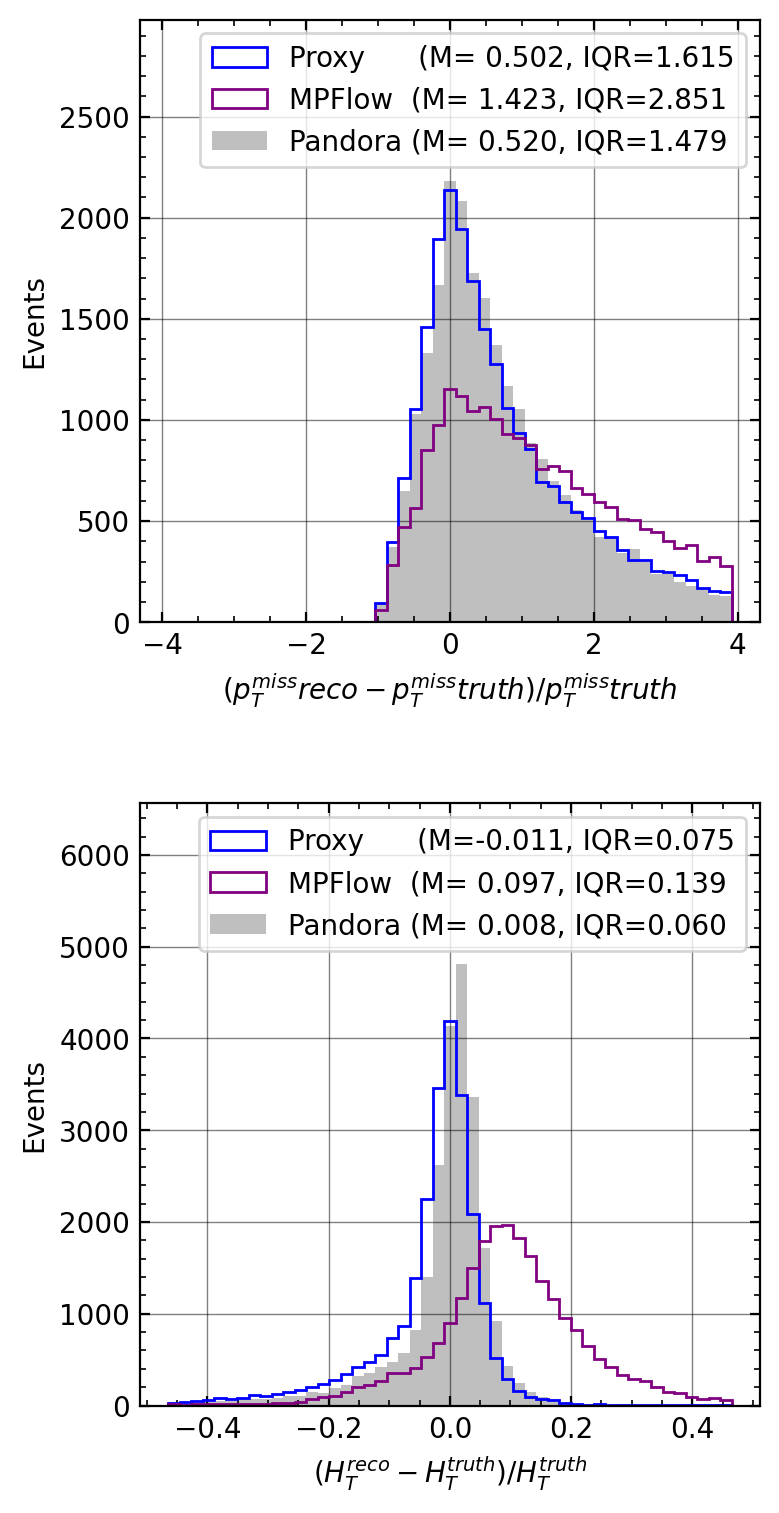

In [ ]:
met_res_and_ht_res_input_dict = {
    "proxy": [perf_obj.data["mpflow"]["proxy_pt"], perf_obj.data["mpflow"]["proxy_phi"]],
    "mpflow": [perf_obj.data["mpflow"]["pt"], perf_obj.data["mpflow"]["phi"]],
    "pandora": [perf_obj.truth_dict["pandora_pt"], perf_obj.truth_dict["pandora_phi"]],
}
figs = plot_met_res_and_ht_res(
    perf_obj.truth_dict["particle_pt"], perf_obj.truth_dict["particle_phi"], met_res_and_ht_res_input_dict, stylesheet=None, separate_figures=False
)
if SAVE_FIG:
    if isinstance(figs, list):
        for i, f in enumerate(figs):
            f.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res_{i}.png", dpi=300)
    else:
        figs.savefig(f"{save_dir}/clic_dijet_met_res_and_ht_res.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:135: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))
/tmp/ipykernel_35356/907927751.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


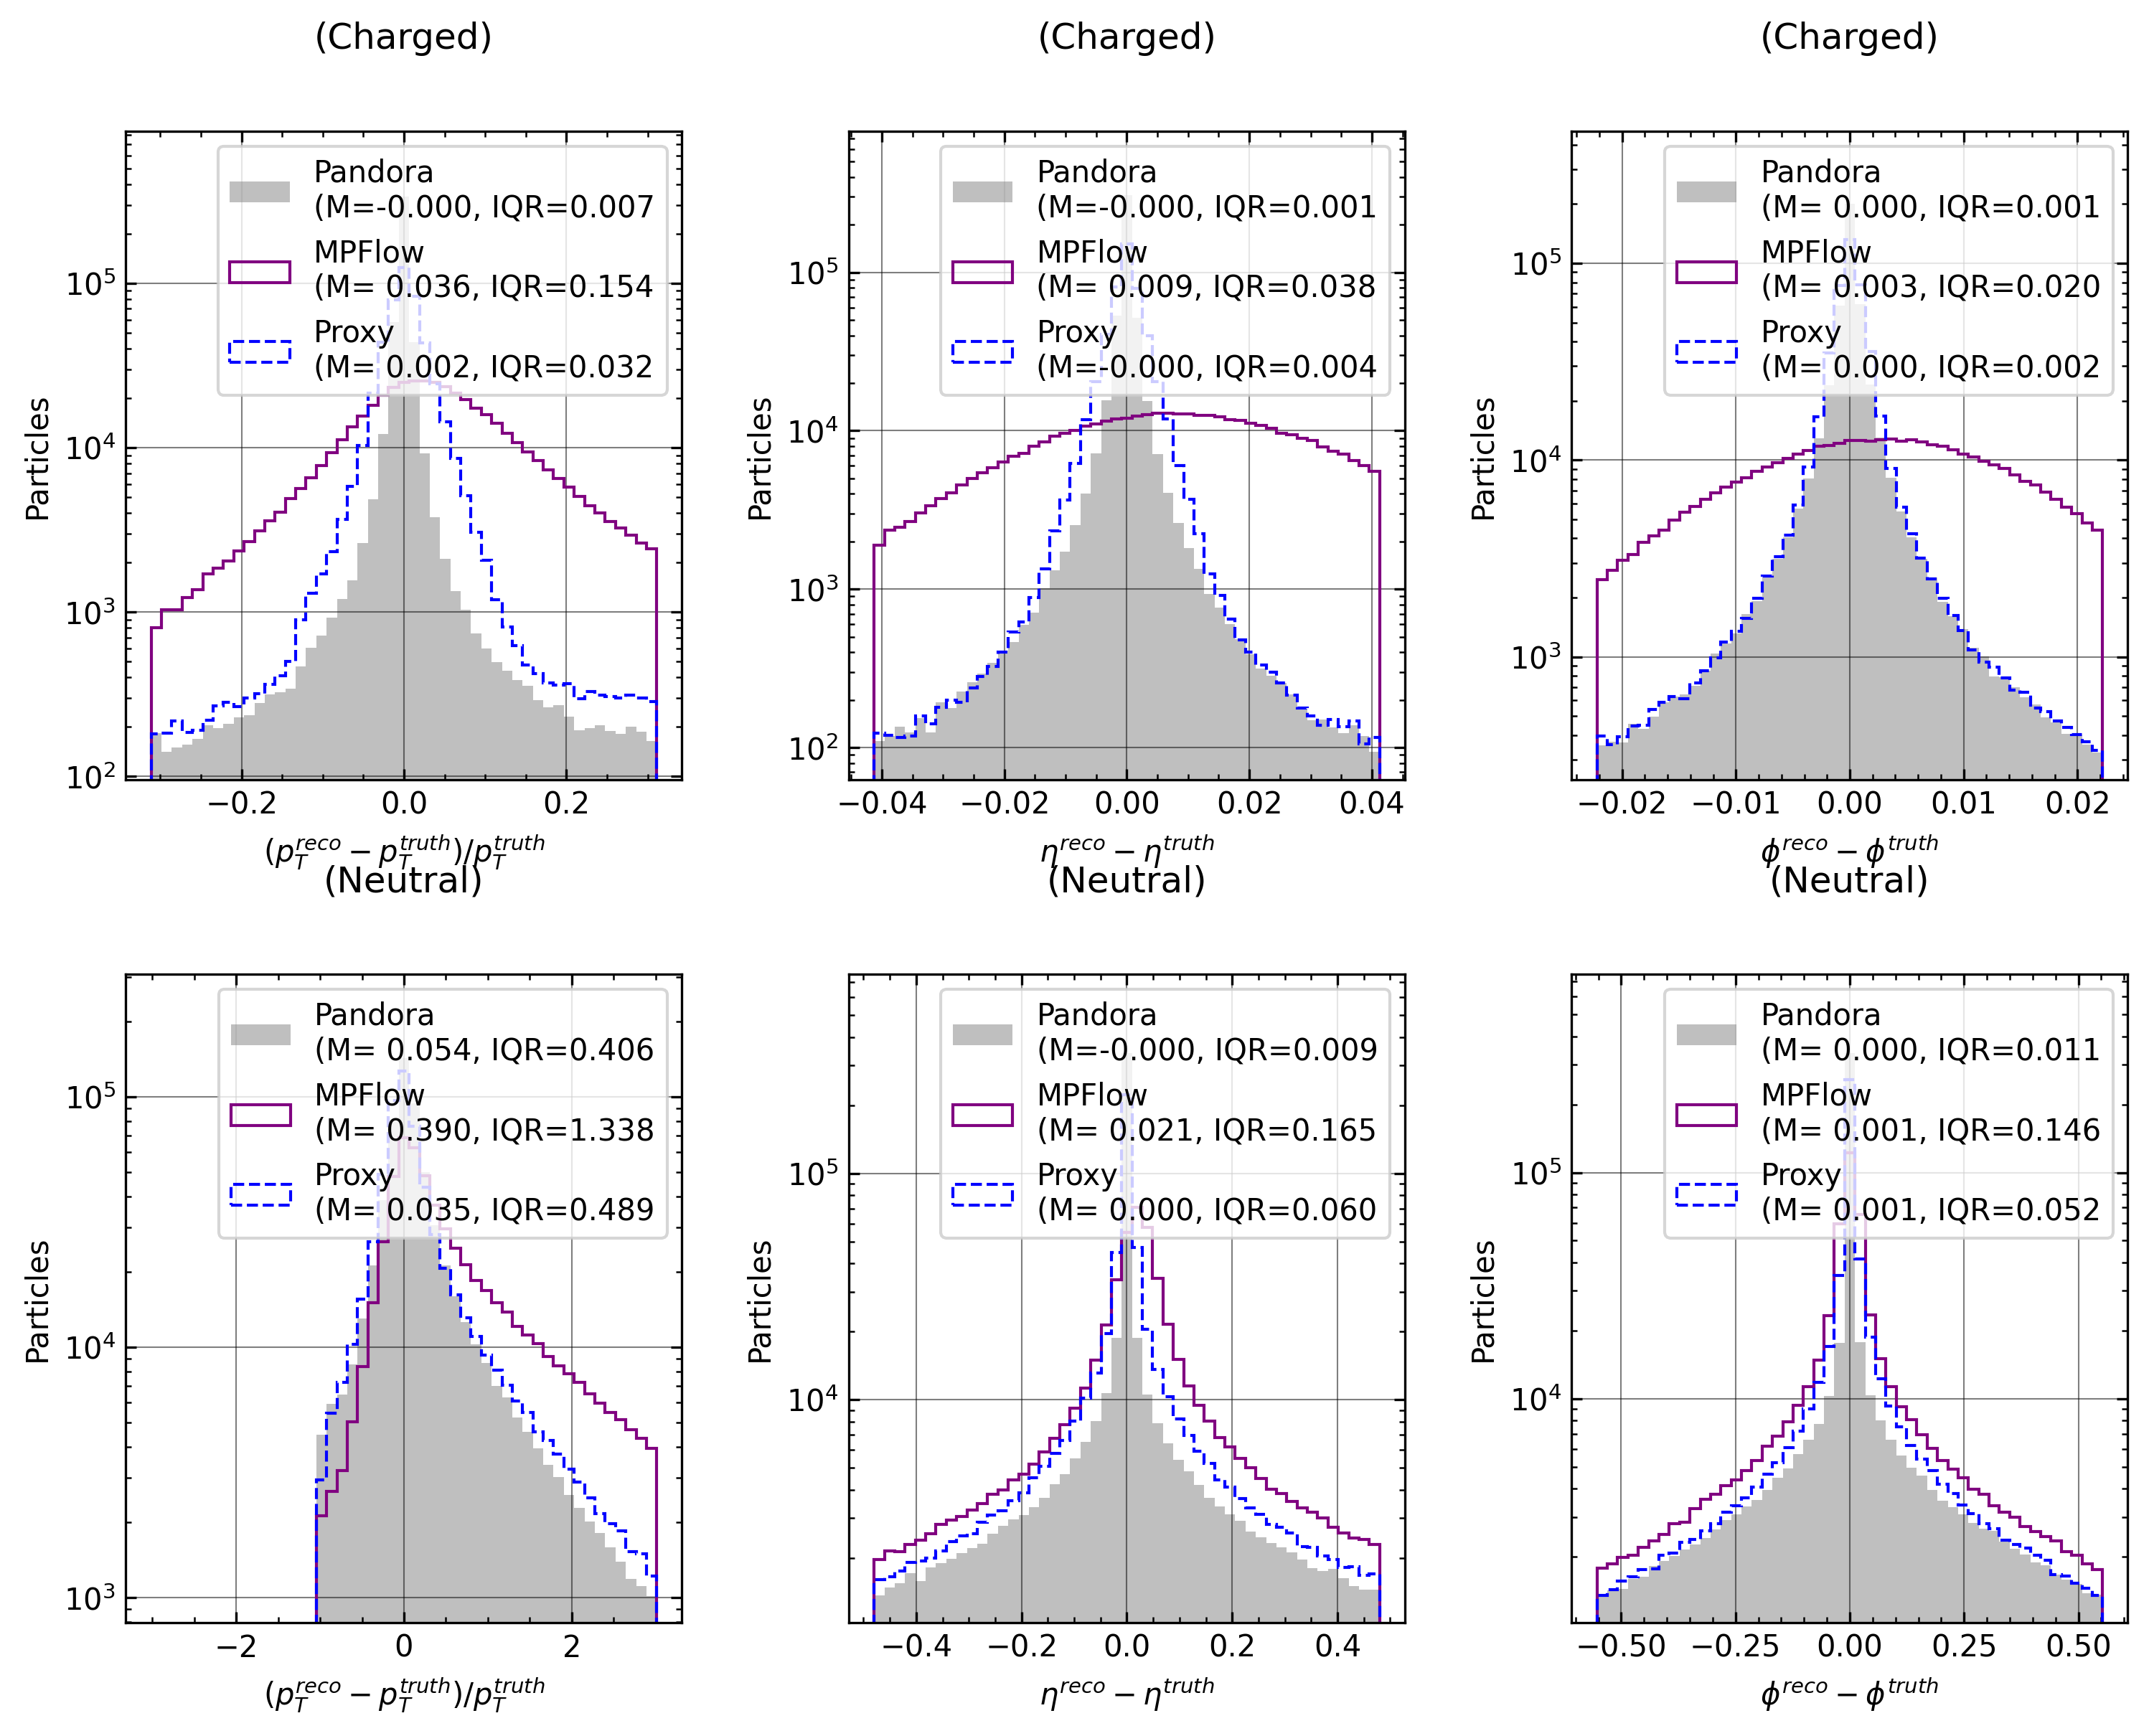

In [ ]:
# from pflow.performance.plot_helper_particle import plot_residuals
from hepattn.experiments.clic.performance.style_sheet import LINE_STYLES

style_sheet_part_res = {
    "LINE_STYLES": deepcopy(LINE_STYLES),
}
style_sheet_part_res["LINE_STYLES"]["proxy"] = "--"
# style_sheet_part_res['COLORS']['proxy'] = 'dodgerblue'
# style_sheet_part_res['LINE_STYLES']['proxy'] = '-'

_dict = {
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
}

qs = {"Charged": {"pt": 90, "eta": 80, "phi": 80}, "Neutral": {"pt": 90, "eta": 80, "phi": 80}}
fig = plot_residuals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=style_sheet_part_res)
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{save_dir}/dijet_particle_residuals.png", dpi=300, bbox_inches="tight")

In [ ]:
_dict = {
    "proxy": perf_obj.data["mpflow"]["matched_proxy_particles"],
    "pandora": perf_obj.truth_dict["matched_pandora_particles"],
    "mpflow": perf_obj.data["mpflow"]["matched_particles"],
}

qs = {"Neutral hadron": {"pt": 98, "eta": 75, "phi": 75}, "Photon": {"pt": 99, "eta": 90, "phi": 90}}
figs = plot_residuals_neutrals(_dict, pt_relative=True, log_y=True, qs=qs, stylesheet=None, separate_figures=False)
if SAVE_FIG:
    if isinstance(figs, list):
        figs[0].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_pt.png", dpi=300, bbox_inches="tight")
        figs[1].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_eta.png", dpi=300, bbox_inches="tight")
        figs[2].savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_phi.png", dpi=300, bbox_inches="tight")
        figs[3].savefig(f"{save_dir}/dijet_particle_residuals_photon_pt.png", dpi=300, bbox_inches="tight")
        figs[4].savefig(f"{save_dir}/dijet_particle_residuals_photon_eta.png", dpi=300, bbox_inches="tight")
        figs[5].savefig(f"{save_dir}/dijet_particle_residuals_photon_phi.png", dpi=300, bbox_inches="tight")
    else:
        figs.savefig(f"{save_dir}/dijet_particle_residuals_neutralhad_photon.png", dpi=300, bbox_inches="tight")

/share/gpu1/syw24/hepattn/src/hepattn/experiments/clic/performance/plot_helper_particle.py:234: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, ax.get_ylim()[1] * (1 + len(residual_dict) * 0.23))


In [ ]:
perf_obj.hung_match_particles(flatten=False, return_unmatched=True)

Matching particles...:   5%|█████▊                                                                                                                       | 1142/24728 [00:00<00:08, 2883.41it/s]

Matching particles...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24728/24728 [00:06<00:00, 3932.34it/s]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_matched_event(idx):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    ref_class = perf_obj.data["mpflow"]["matched_proxy_particles"][0]["class"][idx]
    comp_class = perf_obj.data["mpflow"]["matched_proxy_particles"][1]["class"][idx]
    comp_class_hgpf = perf_obj.data["mpflow"]["matched_particles"][1]["class"][idx]
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["phi"][idx][ref_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][0]["eta"][idx][ref_class < 3],
        marker="o",
        s=20,
        color="blue",
        label="Truth",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["phi"][idx][comp_class < 3],
        perf_obj.data["mpflow"]["matched_proxy_particles"][1]["eta"][idx][comp_class < 3],
        marker="x",
        s=20,
        color="orange",
        label="Proxy",
    )
    ax.scatter(
        perf_obj.data["mpflow"]["matched_particles"][1]["phi"][idx][comp_class_hgpf < 3],
        perf_obj.data["mpflow"]["matched_particles"][1]["eta"][idx][comp_class_hgpf < 3],
        marker="^",
        s=20,
        color="red",
        label="MPflow",
        alpha=0.5,
    )
    fig.suptitle(f"Event {idx}")
    ax.set_xlabel("Phi")
    ax.set_ylabel("Eta")
    fig.legend()
    fig.tight_layout()
    fig.show()

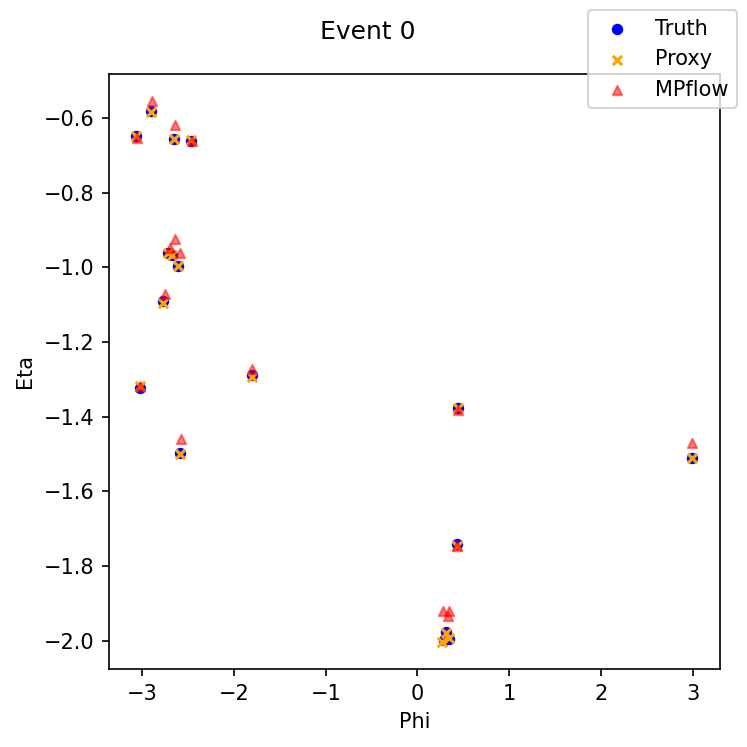

In [ ]:
plot_matched_event(0)